In [1]:
%reload_ext autoreload
%autoreload 2

In [20]:
import sys, os
# Get absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/workspace/scripts")

import numpy as np
import pandas as pd
import seaborn as sns
import pickle, os

from utils.io.io_results import load_fc_combined_data
from utils.functional_connectivity.fc_compute import bin_fcs_by_freq
from utils.functional_connectivity.fc_aggregate_network import aggregate_to_network_fc
from utils.functional_connectivity.fc_analysis import analyze_similarity_by_imf, compute_similarity_matrix, group_similarity_means, permutation_test_within_vs_between
from utils.plot.plot_summary import plot_similarity_by_imf, plot_similarity_by_band, plot_imf_frequency_distribution
from utils.plot.plot_base import set_mpl_style
from utils.plot.plot_fc import plot_fc_subject_combined

# --- Load combined FCs ---
RES_DIR = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/vlmd/combined_fc"

In [12]:
sns.set_theme(context="paper", style="white", font_scale=1.0)
set_mpl_style()

### Similarity analysis

[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/vlmd/combined_fc


/cluster/home/herminea/mental_health_project/workspace/utils/functional_connectivity/fc_analysis.py:41: RuntimeWarning: Mean of empty slice
  HC_HC   = np.nanmean(sim[np.ix_(hc_idx, hc_idx)][~np.eye(len(hc_idx), dtype=bool)])
/cluster/home/herminea/mental_health_project/workspace/utils/functional_connectivity/fc_analysis.py:42: RuntimeWarning: Mean of empty slice
  MDD_HC  = np.nanmean(sim[np.ix_(mdd_idx, hc_idx)])
/cluster/home/herminea/.conda/envs/neuro/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/home/herminea/.conda/envs/neuro/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


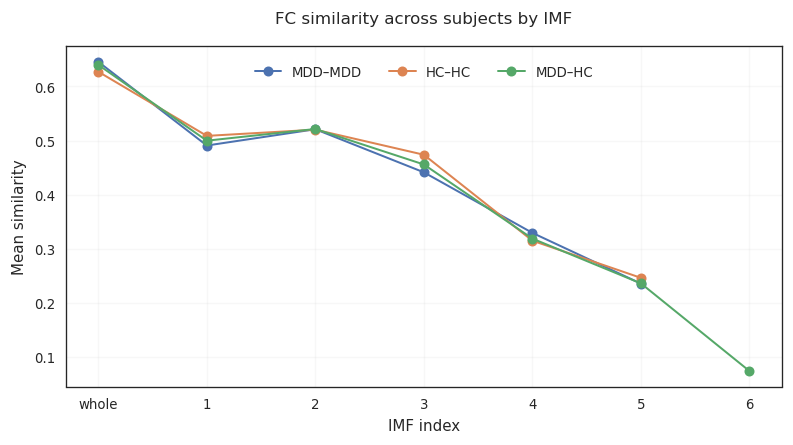

(<Figure size 780x432 with 1 Axes>,
 <Axes: title={'center': 'FC similarity across subjects by IMF'}, xlabel='IMF index', ylabel='Mean similarity'>)

In [13]:
subjects_combined, fcs_by_imf, groups, freqs_by_imf = load_fc_combined_data(RES_DIR)
summary_imf = analyze_similarity_by_imf(fcs_by_imf, groups)
summary_imf["IMF"] = summary_imf["IMF"].astype(str)

plot_similarity_by_imf(
    summary_imf,
    outpath_no_ext="results/figures/mfc_analysis/similarity_by_imf"
)


### IMF frequency distribution

In [14]:
all_freqs = []
all_labels = []
for subj, entry in subjects_combined.items():
    freqs = entry[0]["freqs"]
    group = entry[0]["group"]
    for i, f in enumerate(freqs, start=1):
        all_freqs.append(f)
        all_labels.append((group, i-1))

df = pd.DataFrame(all_labels, columns=["Group", "IMF"])
df["Frequency"] = all_freqs

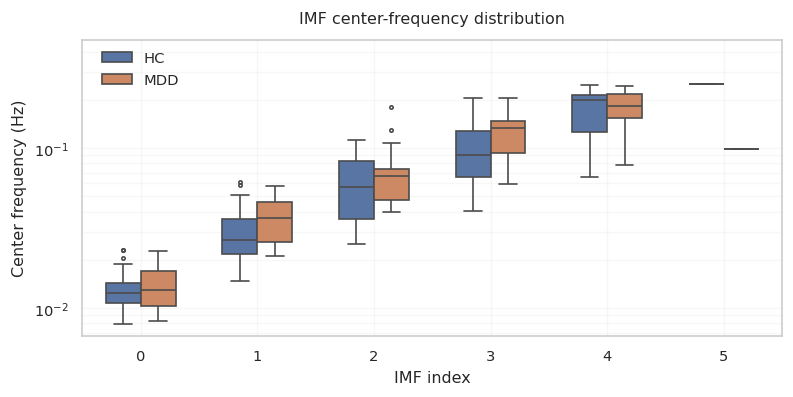

(<Figure size 780x384 with 1 Axes>,
 <Axes: title={'center': 'IMF center-frequency distribution'}, xlabel='IMF index', ylabel='Center frequency (Hz)'>)

In [15]:
plot_imf_frequency_distribution(
    df,
    outpath_no_ext="results/figures/mfc_analysis/imf_frequency_boxplot"
)

#### Frequency bands

In [16]:
freq_bands = {
    "Slow-5": (0.01, 0.027),
    "Slow-4": (0.027, 0.073),
    "Slow-3": (0.073, 0.198),
    "Slow-2": (0.198, 0.25),
}

fcs_by_band = bin_fcs_by_freq(subjects_combined, freq_bands)
fcs_by_band["Whole"] = {s: fcs_by_imf["whole"][s] for s in fcs_by_imf["whole"]}

from collections import OrderedDict

order = ["Whole", "Slow-6", "Slow-5", "Slow-4", "Slow-3", "Slow-2"]
fcs_by_band = OrderedDict((k, fcs_by_band[k]) for k in order if k in fcs_by_band)

summary_band = []
for band, fcs in fcs_by_band.items():
    sim, subs = compute_similarity_matrix(fcs)
    MDD_MDD, HC_HC, MDD_HC = group_similarity_means(sim, subs, groups)
    diff, pval = permutation_test_within_vs_between(sim, subs, groups)
    summary_band.append((band, MDD_MDD, HC_HC, MDD_HC, diff, pval))
summary_band = pd.DataFrame(summary_band, columns=["Band", "MDD–MDD", "HC–HC", "MDD–HC", "Δ", "p"])
print(summary_band)

     Band   MDD–MDD     HC–HC    MDD–HC         Δ       p
0   Whole  0.645664  0.627328  0.639983 -0.003487  0.3204
1  Slow-5  0.535913  0.532926  0.534576 -0.000231  0.9466
2  Slow-4  0.507564  0.522275  0.516290 -0.001739  0.6066
3  Slow-3  0.351538  0.362074  0.351215  0.003835  0.5556
4  Slow-2  0.229940  0.233955  0.235033 -0.002799  0.7160


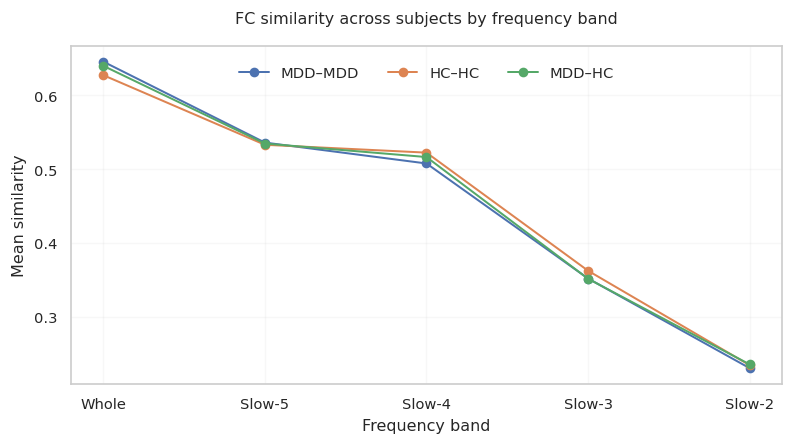

(<Figure size 780x432 with 1 Axes>,
 <Axes: title={'center': 'FC similarity across subjects by frequency band'}, xlabel='Frequency band', ylabel='Mean similarity'>)

In [17]:
plot_similarity_by_band(
    summary_band,
    outpath_no_ext="results/figures/mfc_analysis/similarity_by_band"
)


#### Network aggregation

In [18]:
# --- Load mapping file ---
atlas_df = pd.read_csv("/cluster/home/herminea/mental_health_project/workspace/atlas/roi_to_net_434.csv")

# --- Extract columns cleanly ---
atlas_df["NetworkID"] = pd.to_numeric(atlas_df["NetworkID"], errors="coerce").astype(int)
atlas_df["NetworkName"] = atlas_df["NetworkName"].astype(str)


# ROI → network mapping (numeric, 0–20)
roi_to_net = atlas_df["NetworkID"].values
n_networks = len(np.unique(roi_to_net))

# --- Group by numeric ID and take the first name per network ---
net_names_21 = (
    atlas_df.groupby("NetworkID")["NetworkName"]
    .first()
    .to_list()
)

binned_netfcs = {
    band: {s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
           for s, fc in subj_dict.items()}
    for band, subj_dict in fcs_by_band.items()
}

whole_netfcs = {
    s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
    for s, fc in fcs_by_imf["whole"].items()
}

z_binned_netfcs = {}

for band, subj_fcs in binned_netfcs.items():
    z_binned_netfcs[band] = {}
    for s, fc in subj_fcs.items():
        # Assume fc is Pearson r. Clip to avoid infs.
        fc_clipped = np.clip(fc, -0.999999, 0.999999)
        z_binned_netfcs[band][s] = np.arctanh(fc_clipped)  # Fisher z

#### Visualization

In [21]:
mdd_subjects = [s for s, g in groups.items() if g == "MDD"]
hc_subjects  = [s for s, g in groups.items() if g == "HC"]

for idx, s in enumerate(mdd_subjects[:1], start=1):
    path = os.path.join(RES_DIR, f"{s}_combined_fc.pkl")
    with open(path, "rb") as f:
        subj_data = pickle.load(f)

    agg_fc_modes = [aggregate_to_network_fc(fc, roi_to_net, n_networks)
                    for fc in subj_data["fc_modes"]]
    agg_fc_whole = aggregate_to_network_fc(subj_data["fc_whole"], roi_to_net, n_networks)

    subj_data["fc_net"] = np.stack(agg_fc_modes, axis=0)
    subj_data["fc_whole_net"] = agg_fc_whole   # recommended: don’t overwrite fc_whole

    plot_fc_subject_combined(
        s, {s: subj_data},
        subj_display=f"Subject {idx:02d}",
        use_network=True,
        show_sparse_ticks=True,
        ticks_on="all",
        save=True
    )

Saved results/figures/fc_subjects/NDAR_INVBL733HBP_MDD_net_combined_fc.pdf
